In [51]:
import csv
from collections import defaultdict, Counter
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib
from scipy.stats.contingency import odds_ratio

# Load Data

In [52]:
colors = ['#d62a5f', '#23aedc', '#d0bf4d', '#2d3594', '#d62a5f']


In [104]:
# load data
attributes = ['ASD', 'noise','verbal',  'motor', 'sleep', 'gi', 'infections',  
              'seizures', 'metabolic', 'premature', 'vision', 'hearing', ]
attribute_to_index = dict([(x, i) for i, x in enumerate(attributes)])

comorbidities = ['Speech / Language Disorder', 
                 'Intellectual disability / global developmental delay', 
                 'Attention Deficit Hyperactivity Disorder (ADD/ADHD)',
                 'Oppositional Defiant / Conduct/ Disruptive Behavior Disorder',
                 'Specific learning disorder - reading',
                 'Specific learning disorder - math',
                 'Specific learning disorder - written expression',
                 'Anxiety',
                 'Motor / Developmental Coordination Disorder',
                 'Depression',
                 'Bipolar Disorder / Mania',
                 'Obsessive Compulsive Disorder (OCD)',
                 "Tic disorder / Tourette's",
                 'Feeding or eating disorder',
                 'Elimination Disorder']
comorbidity_to_abbrev = {
    'Speech / Language Disorder': 'SLD',
    'Intellectual disability / global developmental delay': 'ID'
}
comorbidity_to_index = dict([(x, i) for i, x in enumerate(comorbidities)])


class Child():
    def __init__(self, data, attribute_indices, comorbidity_indices, scq_indices):
        # basic info
        self.family = data[0]
        self.id = data[1]
        self.paternal = data[2]
        self.maternal = data[3]
        self.sex = data[4]
        self.age = None if data[5]=='' or int(data[5])<0 or int(data[5])>90 else int(data[5])
        self.asd = data[6]
        self.relatedness = data[7]
        self.group = data[20]
        
        # attributes
        self.attributes = [None if data[i]=='' else data[i] for i in attribute_indices]
        self.has_attributes_data = np.all([y is not None for y in self.attributes])
        if not self.has_attributes_data:
            self.attributes = [None]*len(attributes)
        
        
        # comorbidities
        self.has_comorbidities_data = data[21]=='yes'
        if self.has_comorbidities_data:
            self.comorbidities = [data[i]=='1' for i in comorbidity_indices]
        else:
            self.comorbidities = [None]*len(comorbidities)
        
        # SCQ
        self.SCQ = [None if data[i]=='' else data[i] for i in scq_indices]
        self.has_SCQ_data = np.any([y is not None for y in self.SCQ])
    

    def __str__(self):
        return 'Child(id=%s, fam=%s)' % (self.id, self.family)

fam_to_children = defaultdict(list)
children = []
attribute_indices = [None]*len(attributes)
comorbidity_indices = [None]*len(comorbidities)
scq_indices = [None]*40

with open('../data/kfExport_02-04-2023_fullSample_allColumns.csv', 'r') as f:
    reader = csv.reader(f)
    header = [x.strip() for x in next(reader)]
    
    for i, h in enumerate(header):
        if h in attributes:
            attribute_indices[attributes.index(h)] = i
        elif h in comorbidities:
            comorbidity_indices[comorbidities.index(h)] = i
        elif h.startswith('SCQ'):
            scq_indices[int(h.split()[1])-1] = i

    assert np.all([x is not None for x in attribute_indices])
    assert np.all([x is not None for x in comorbidity_indices])
    assert np.all([x is not None for x in scq_indices])
    
    for line in reader:
        child = Child(line, attribute_indices, comorbidity_indices, scq_indices)
        fam_to_children[child.family].append(child)
        children.append(child)
        
children_f = [x for x in children if x.sex=='female']
children_m = [x for x in children if x.sex=='male']

print('children', len(children), 'female', len(children_f), 'male', len(children_m))

children 6951 female 2318 male 4424


# Binarize and put into numpy arrays

In [105]:
def binarize_attribute(attr, x):
    if attr=='verbal':
        return None if x is None else 'yes' if int(x)<=7 else 'no'
    else:
        return None if x is None else 'yes' if x!='no' else 'no'

In [106]:
# binarize data

# We binarize our attributes for this analysis to make them easier to work with

X_attributes = np.zeros((len(children), len(attributes)))
for i, attr in enumerate(attributes):
    X_attributes[:, i] = [np.nan if child.attributes[i] is None else 1 if binarize_attribute(attr, child.attributes[i])=='yes' else 0 for child in children]

X_scq = np.zeros((len(children), 40))
for i in range(40):
    X_scq[:, i] = [np.nan if child.SCQ[i] is None else 1 if child.SCQ[i]=='1' else 0 for child in children]
    
X_comorbid = np.zeros((len(children), len(comorbidities)))
for i in range(len(comorbidities)):
    X_comorbid[:, i] = [np.nan if child.comorbidities[i] is None else 1 if child.comorbidities[i]==True else 0 for child in children]
    
X = np.hstack((X_attributes, X_scq, X_comorbid))
    
sex = np.array([np.nan if child.sex is None else 1 if child.sex=='male' else 0 for child in children])
age = np.array([np.nan if child.age is None else child.age for child in children])
asd = np.array([np.nan if child.asd is None else 1 if child.asd=='yes' else 0 for child in children])

print(sex.shape)
print(age.shape)
print(asd.shape)
print(X_attributes.shape)
print(X_scq.shape)
print(X_comorbid.shape)

(6951,)
(6951,)
(6951,)
(6951, 12)
(6951, 40)
(6951, 15)


In [107]:
# This is where all the work is. We use statsmodels to implement logistic regression
# We're essentially trying to predict attribute j using attribute i, as well as all of our confounders
# This method returns the parameters (log odds for a unit change in the feature), along with confidence intervas
# around the parameters and pvalues
# You get parameters, confidence intervals, and pvalues for attribute i as well as all of the confounders used

def calculate_association(values_i, values_j, *confounders):
        
    has_no_nulls = ~np.isnan(values_i) & ~np.isnan(values_j)
    for c in confounders:
        has_no_nulls = has_no_nulls & ~np.isnan(c)
    #print('included', np.sum(has_no_nulls))
    
    X = np.hstack([values_i[:, np.newaxis],] + [c[:, np.newaxis] for c in confounders] + [np.ones((len(has_no_nulls), 1))])[has_no_nulls, :]
    y = values_j[has_no_nulls]
        
    model = sm.Logit(y, X)
    result = model.fit(disp=False)
    
    return result.params, result.conf_int(), result.pvalues

# Calculate association between attributes using sex and age as confounders

In [108]:
# For our first analysis, we look at the association between pairs of attributes after controlling for sex and age

num_tests = 0
log_odds, log_odds_conf, pvalues = np.zeros((len(attributes), X.shape[1])), np.zeros((len(attributes), X.shape[1], 2)), np.zeros((len(attributes), X.shape[1]))
sex_log_odds, sex_log_odds_conf, sex_pvalues = np.zeros((len(attributes), X.shape[1])), np.zeros((len(attributes), X.shape[1], 2)), np.zeros((len(attributes), X.shape[1]))
age_log_odds, age_log_odds_conf, age_pvalues = np.zeros((len(attributes), X.shape[1])), np.zeros((len(attributes), X.shape[1], 2)), np.zeros((len(attributes), X.shape[1]))

for i in range(len(attributes)):
    for j in range(X.shape[1]):
        if i != j:
            try:
                coeff, confint, pvalue = calculate_association(X[:, j], X[:, i],
                                                              sex, age)
                pvalues[i, j] = pvalue[0]
                log_odds[i, j] = coeff[0]
                log_odds_conf[i, j, :] = confint[0, :]
                sex_pvalues[i, j] = pvalue[1]
                sex_log_odds[i, j] = coeff[1]
                sex_log_odds_conf[i, j, :] = confint[1, :]
                age_pvalues[i, j] = pvalue[2]
                age_log_odds[i, j] = coeff[2]
                age_log_odds_conf[i, j, :] = confint[2, :]

                num_tests += 1
            except:
                pass
            
pvalues_clipped = pvalues.copy()
pvalues_clipped[pvalues_clipped>0.05/num_tests] = np.nan
pvalues_clipped[np.arange(len(attributes)), np.arange(len(attributes))] = np.nan

sex_pvalues_clipped = sex_pvalues.copy()
sex_pvalues_clipped[sex_pvalues_clipped>0.05/num_tests] = np.nan
sex_pvalues_clipped[np.arange(len(attributes)), np.arange(len(attributes))] = np.nan

age_pvalues_clipped = age_pvalues.copy()
age_pvalues_clipped[age_pvalues_clipped>0.05/num_tests] = np.nan
age_pvalues_clipped[np.arange(len(attributes)), np.arange(len(attributes))] = np.nan


/Users/kelley/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


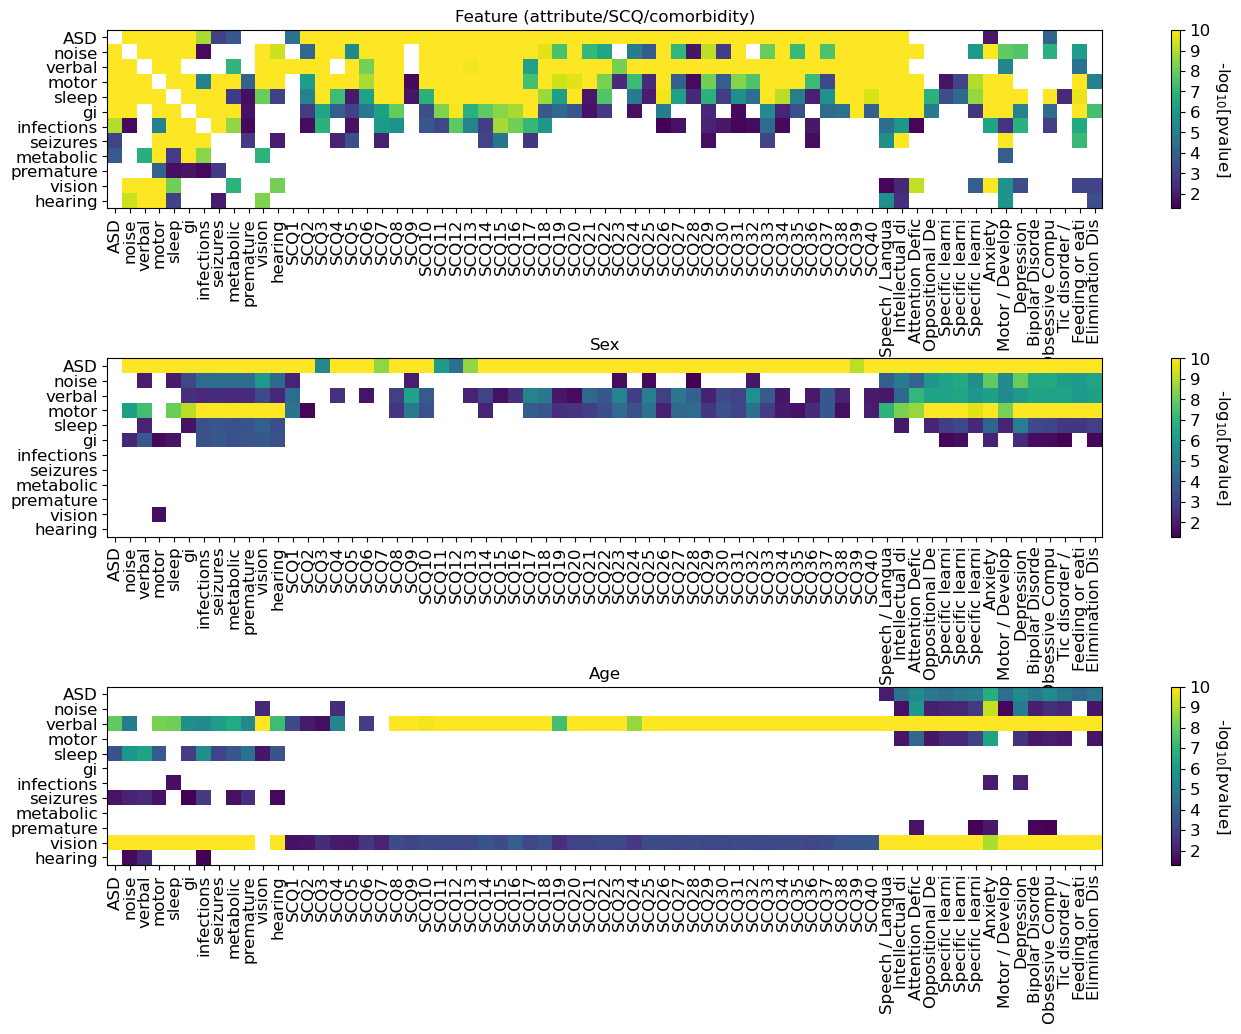

In [109]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.imshow(np.clip(-np.log10(pvalues_clipped*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(range(X.shape[1]), attributes + ['SCQ%d' % i for i in range(1, 41)] + [x[:15] for x in comorbidities], rotation=90, fontsize=12)
plt.yticks(range(len(attributes)), attributes, fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
plt.title('Feature (attribute/SCQ/comorbidity)')


plt.subplot(3, 1, 2)
plt.imshow(np.clip(-np.log10(sex_pvalues_clipped*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(range(X.shape[1]), attributes + ['SCQ%d' % i for i in range(1, 41)] + [x[:15] for x in comorbidities], rotation=90, fontsize=12)
plt.yticks(range(len(attributes)), attributes, fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
plt.title('Sex')

plt.subplot(3, 1, 3)
plt.imshow(np.clip(-np.log10(age_pvalues_clipped*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(range(X.shape[1]), attributes + ['SCQ%d' % i for i in range(1, 41)] + [x[:15] for x in comorbidities], rotation=90, fontsize=12)
plt.yticks(range(len(attributes)), attributes, fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
plt.title('Age')

plt.tight_layout()
plt.show()

# Fig 5

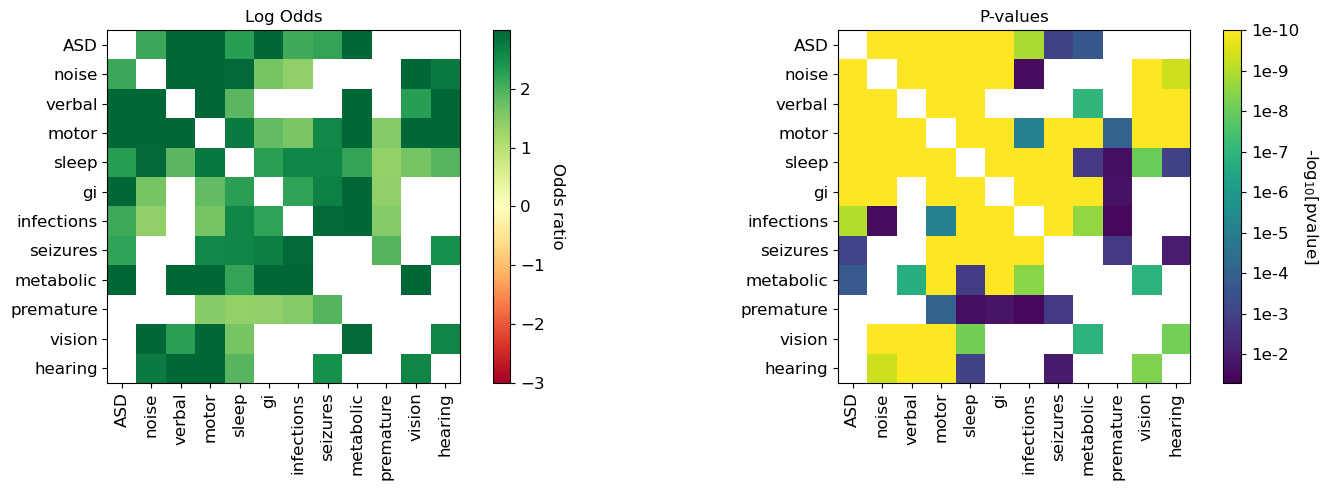

In [111]:
def plot_param_pvalue_grid(params, pvalues_clipped):

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)

    params_sig = params.copy()
    params_sig[np.isnan(pvalues_clipped)] = np.nan

    plt.imshow(np.exp(params_sig[:, :len(attributes)]), cmap='RdYlGn', vmax=3, vmin=-3)
    cbar = plt.colorbar(ticks=np.arange(-3, 3))
    plt.xticks(range(len(attributes)), attributes, rotation=90, fontsize=12)
    plt.yticks(range(len(attributes)), attributes, fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Odds ratio', rotation=270, fontsize=12, labelpad=15)
    plt.title('Log Odds')

    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(-np.log10(pvalues_clipped[:, :len(attributes)]*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
    cbar = plt.colorbar(ticks=np.arange(11))
    cbar.ax.set_yticklabels(['1e-%d' % x for x in range(0, 11)])
    plt.xticks(range(len(attributes)), attributes, rotation=90, fontsize=12)
    plt.yticks(range(len(attributes)), attributes, fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
    plt.title('P-values')

    plt.tight_layout()
    plt.show()


plot_param_pvalue_grid(log_odds, pvalues_clipped)


# Fig 7

/var/folders/hp/72rjd_x140qf9f9d9f4hy40c0000gp/T/ipykernel_40762/592105234.py:8: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.exp(log_odds[0, :len(attributes)]), -np.log10(pvalues[0, :len(attributes)]),


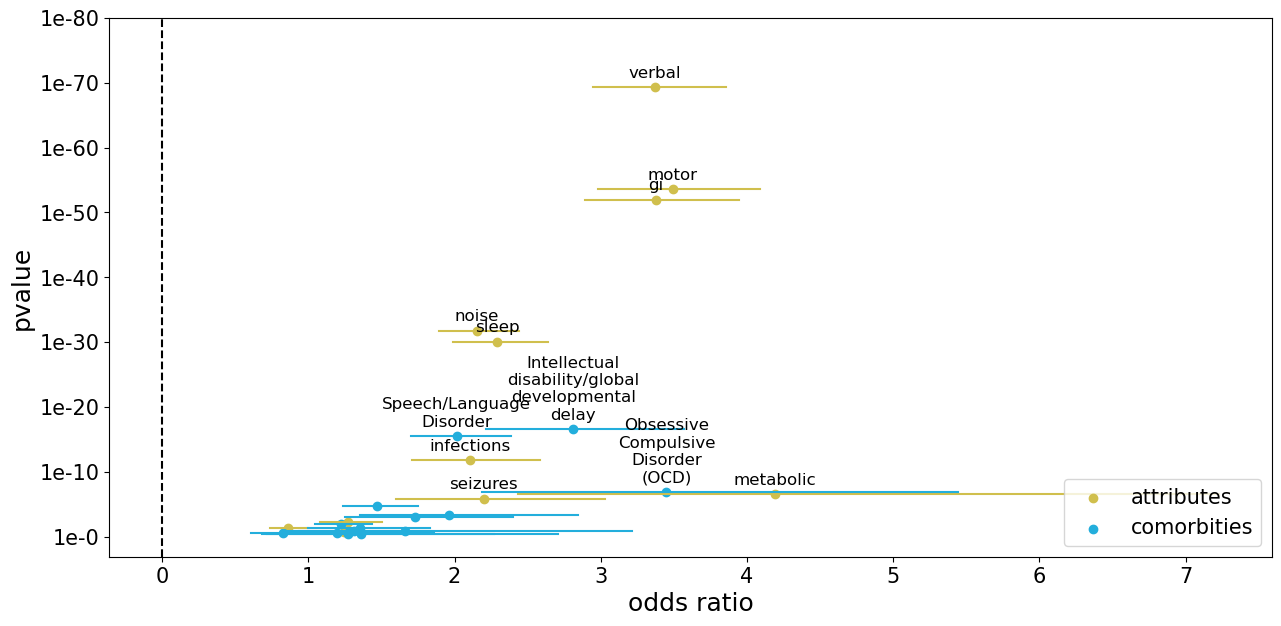

In [75]:
plt.figure(figsize=(15, 7))

for i, attr in enumerate(attributes):
    if i != 0:
        plt.plot(np.exp(log_odds_conf[0, i, :]), -np.log10([pvalues[0, i]*num_tests, pvalues[0, i]*num_tests]), color=colors[2])
        if np.exp(log_odds[0, i])>1.5 and pvalues[0, i]*num_tests<0.05:
            plt.text(np.exp(log_odds[0, i]), -np.log10(pvalues[0, i]*num_tests)+1, attr, ha='center', va='bottom', fontsize=12)
plt.scatter(np.exp(log_odds[0, :len(attributes)]), -np.log10(pvalues[0, :len(attributes)]), 
            color=colors[2], label='attributes')

#for i in range(len(attributes), len(attributes)+40):
#    plt.plot(np.abs(log_odds_conf[0, i, :]), -np.log10([pvalues[0, i], pvalues[0, i]]), color=colors[0])
#plt.scatter(np.abs(log_odds[0, len(attributes):len(attributes)+40]), -np.log10(pvalues[0, len(attributes):len(attributes)+40]), 
#            color=colors[0], label='SCQ')

for i in range(len(attributes)+40, X.shape[1]):
    plt.plot(np.exp(log_odds_conf[0, i, :]), -np.log10([pvalues[0, i], pvalues[0, i]]), color=colors[1])
    if np.exp(log_odds[0, i])>1.5 and pvalues[0, i]*num_tests<0.05:
        plt.text(np.exp(log_odds[0, i]), -np.log10(pvalues[0, i])+1, comorbidities[i-len(attributes)-40].replace(' / ', '/').replace(' ', '\n'), ha='center', va='bottom', fontsize=12)
plt.scatter(np.exp(log_odds[0, len(attributes)+40:]), -np.log10(pvalues[0, len(attributes)+40:]), 
            color=colors[1], label='comorbities')

#plt.yticks(np.arange(40, 40+len(comorbidities)+len(attrs)), comorbidities+attrs)

plt.axvline(0, color='black', linestyle='--')
#plt.axhspan(40, 40+len(comorbidities), alpha=0.05, color='black')

#plt.xlim([0, 1])
plt.xlabel('odds ratio', fontsize=18)
plt.ylabel('pvalue', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(range(0, 90, 10), ['1e-%d' % x for x in range(0, 90, 10)], fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

# Trying two different methods to visualize params + pvalues

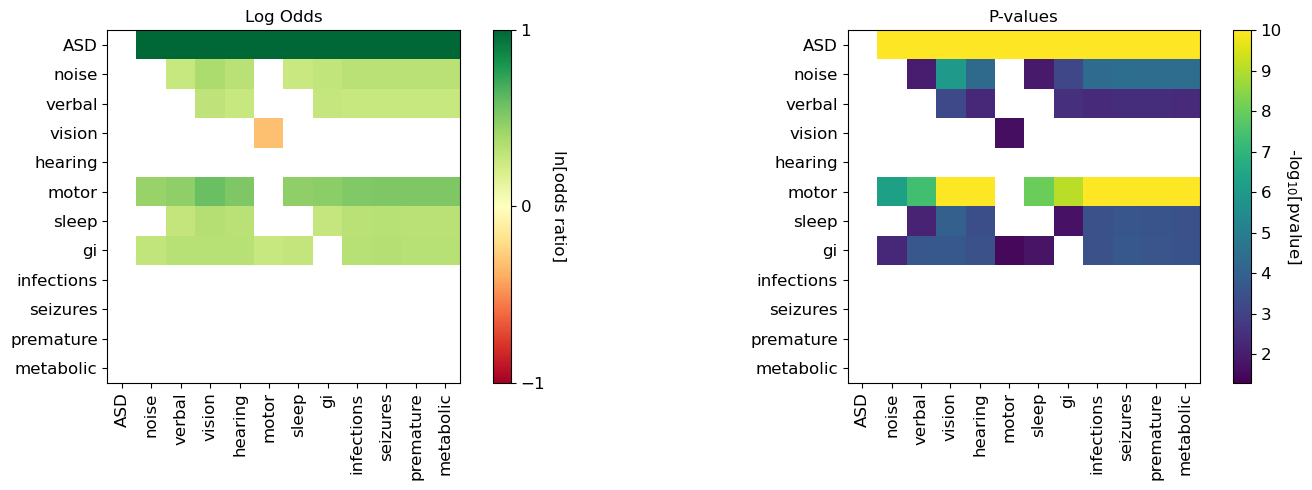

In [39]:
def plot_param_pvalue_grid(params, pvalues_clipped):

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)

    params_sig = params.copy()
    params_sig[np.isnan(pvalues_clipped)] = np.nan

    plt.imshow(params_sig[:, :len(attributes)], cmap='RdYlGn', vmax=1, vmin=-1)
    cbar = plt.colorbar(ticks=np.arange(-10, 11))
    plt.xticks(range(len(attributes)), attributes, rotation=90, fontsize=12)
    plt.yticks(range(len(attributes)), attributes, fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('ln[odds ratio]', rotation=270, fontsize=12, labelpad=15)
    plt.title('Log Odds')

    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(-np.log10(pvalues_clipped[:, :len(attributes)]*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
    cbar = plt.colorbar(ticks=np.arange(11))
    plt.xticks(range(len(attributes)), attributes, rotation=90, fontsize=12)
    plt.yticks(range(len(attributes)), attributes, fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
    plt.title('P-values')

    plt.tight_layout()
    plt.show()
    
plot_param_pvalue_grid(sex_log_odds, sex_pvalues_clipped)


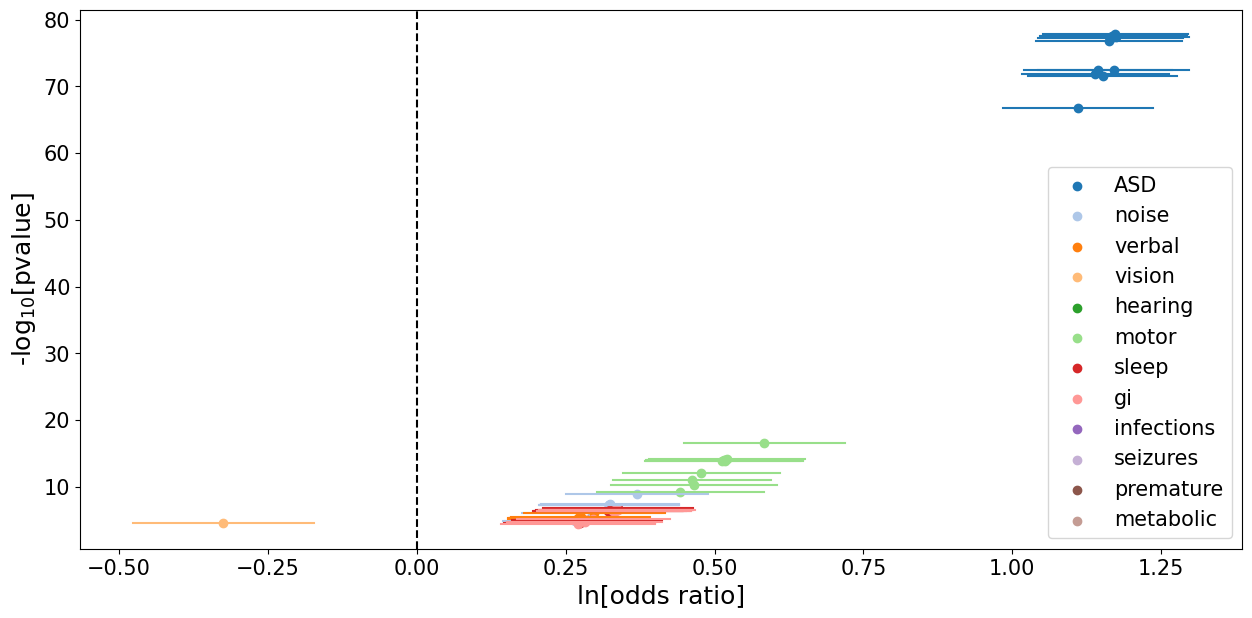

In [40]:
def plot_param_pvalue_volcano(params, conf_ints, pvalues_clipped):

    plt.figure(figsize=(15, 7))
    
    params_sig = params.copy()
    params_sig[np.isnan(pvalues_clipped)] = np.nan

    cmap = plt.get_cmap("tab20")

    for j, attrj in enumerate(attributes):
        for i, attri in enumerate(attributes):
            if i != 0 and not np.isnan(pvalues_clipped[j, i]):
                plt.plot(conf_ints[j, i, :], -np.log10([pvalues_clipped[j, i], pvalues_clipped[j, i]]), color=cmap(j))
                #plt.text(np.abs(log_odds[j, i]), -np.log10(pvalues[j, i])+1, attr, ha='center', va='bottom', fontsize=15)
        plt.scatter(params_sig[j, :len(attributes)], -np.log10(pvalues_clipped[j, :len(attributes)]), 
                    color=cmap(j), label=attrj)

    #plt.yticks(np.arange(40, 40+len(comorbidities)+len(attrs)), comorbidities+attrs)

    plt.axvline(0, color='black', linestyle='--')
    #plt.axhspan(40, 40+len(comorbidities), alpha=0.05, color='black')

    #plt.xlim([0, 1])
    plt.xlabel('ln[odds ratio]', fontsize=18)
    plt.ylabel('-log$_{10}$[pvalue]', fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15, loc='lower right')
    plt.show()
    
plot_param_pvalue_volcano(sex_log_odds, sex_log_odds_conf, sex_pvalues_clipped)


# Calculate association between attributes using sex, age, and asd status as confounders

In [41]:
# Next, we look at the association between pairs of attributes after controling for sex, age, and asd status

num_tests = 0
log_odds_asdconfound, log_odds_conf_asdconfound, pvalues_asdconfound = np.zeros((len(attributes), X.shape[1])), np.zeros((len(attributes), X.shape[1], 2)), np.zeros((len(attributes), X.shape[1]))
sex_pvalues_asdconfound, age_pvalues_asdconfound, asd_pvalues_asdconfound = np.zeros((len(attributes), X.shape[1])), np.zeros((len(attributes), X.shape[1])), np.zeros((len(attributes), X.shape[1]))
for i in range(1, len(attributes)):
    for j in range(1, X.shape[1]):
        if i != j:
            coeff, confint, pvalue = calculate_association(X[:, j], X[:, i],
                                                              sex, age, asd)
            pvalues_asdconfound[i, j] = pvalue[0]
            log_odds_asdconfound[i, j] = coeff[0]
            log_odds_conf_asdconfound[i, j, :] = confint[0, :]
            sex_pvalues_asdconfound[i, j] = pvalue[1]
            age_pvalues_asdconfound[i, j] = pvalue[2]
            asd_pvalues_asdconfound[i, j] = pvalue[3]

            num_tests += 1
            
            

pvalues_asdconfound_clipped = pvalues_asdconfound.copy()
pvalues_asdconfound_clipped[pvalues_asdconfound_clipped>0.05/num_tests] = np.nan
pvalues_asdconfound_clipped[np.arange(len(attributes)), np.arange(len(attributes))] = np.nan

sex_pvalues_asdconfound_clipped = sex_pvalues_asdconfound.copy()
sex_pvalues_asdconfound_clipped[sex_pvalues_asdconfound_clipped>0.05/num_tests] = np.nan
sex_pvalues_asdconfound_clipped[np.arange(len(attributes)), np.arange(len(attributes))] = np.nan

age_pvalues_asdconfound_clipped = age_pvalues_asdconfound.copy()
age_pvalues_asdconfound_clipped[age_pvalues_asdconfound_clipped>0.05/num_tests] = np.nan
age_pvalues_asdconfound_clipped[np.arange(len(attributes)), np.arange(len(attributes))] = np.nan

asd_pvalues_asdconfound_clipped = asd_pvalues_asdconfound.copy()
asd_pvalues_asdconfound_clipped[asd_pvalues_asdconfound_clipped>0.05/num_tests] = np.nan
asd_pvalues_asdconfound_clipped[np.arange(len(attributes)), np.arange(len(attributes))] = np.nan


/Users/kelley/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


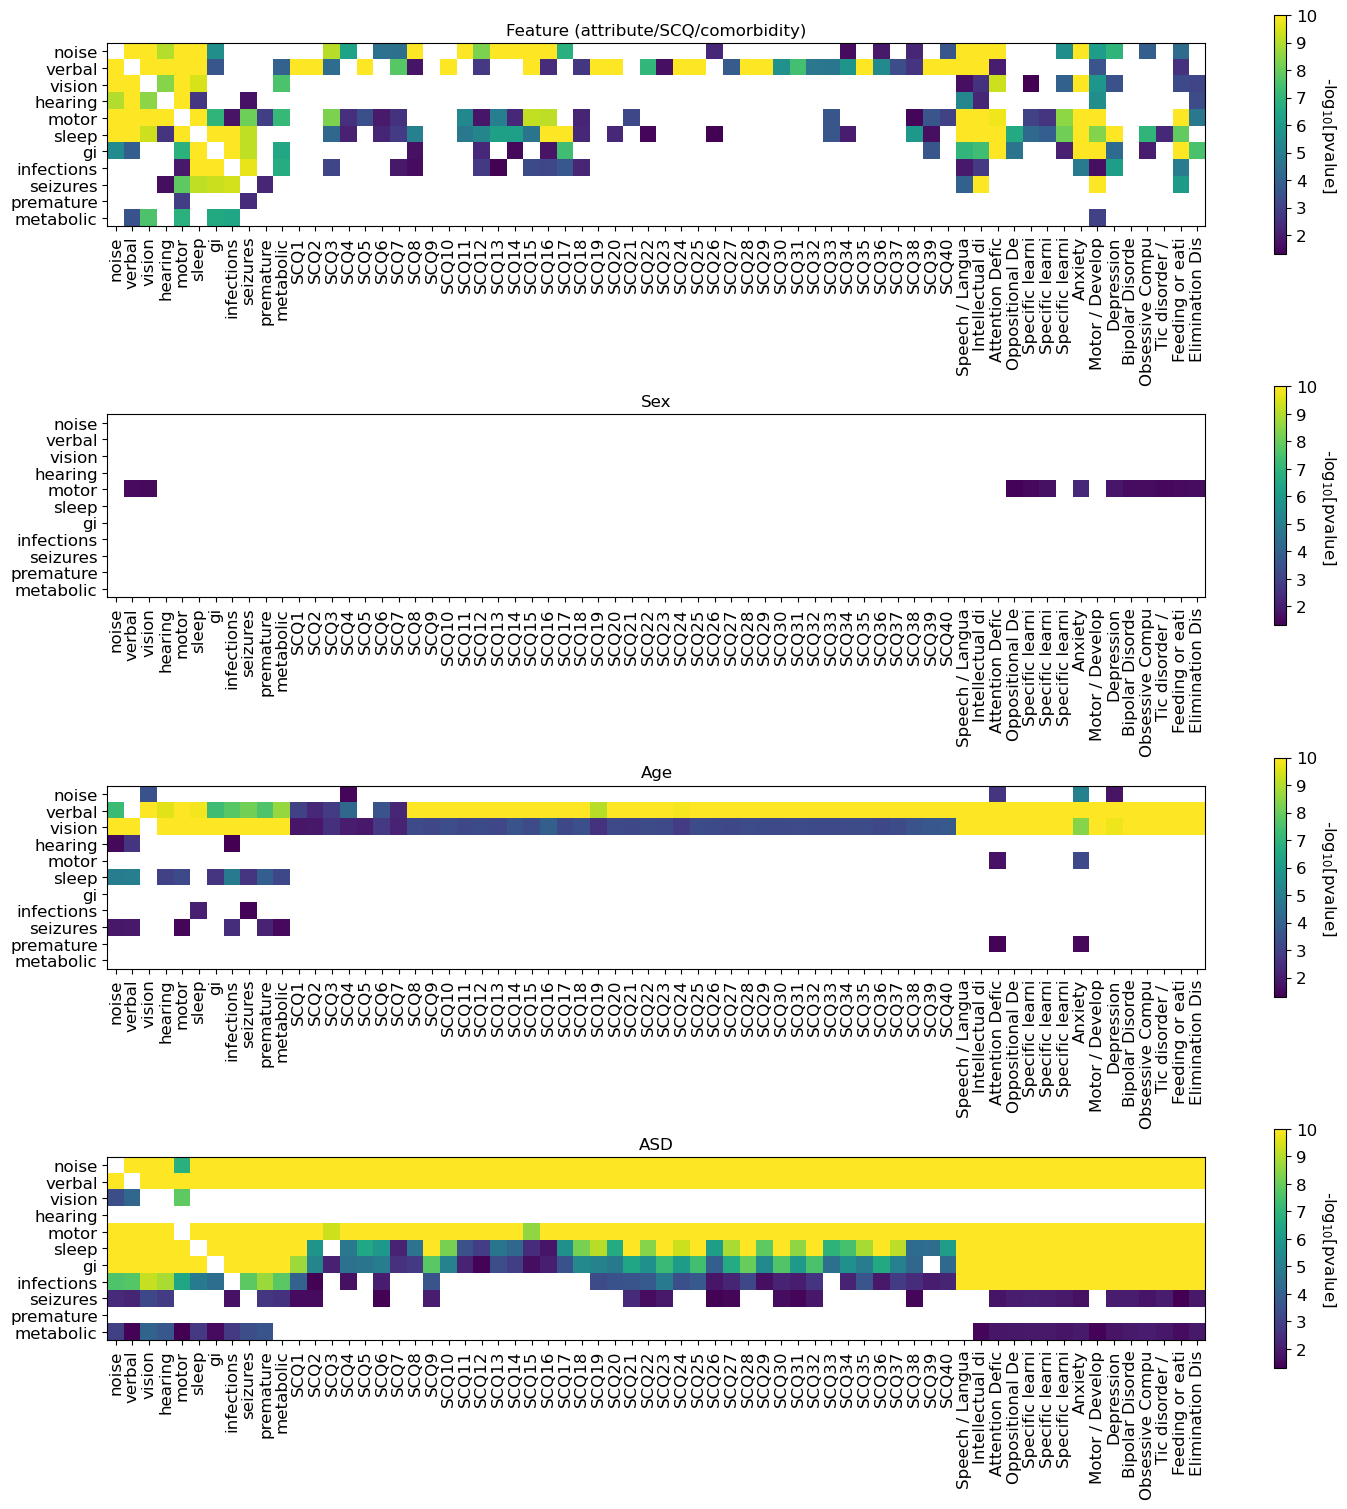

In [42]:
plt.figure(figsize=(15, 15))

plt.subplot(4, 1, 1)
plt.imshow(np.clip(-np.log10(pvalues_asdconfound_clipped[1:, 1:]*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(range(X.shape[1]-1), attributes[1:] + ['SCQ%d' % i for i in range(1, 41)] + [x[:15] for x in comorbidities], rotation=90, fontsize=12)
plt.yticks(range(len(attributes)-1), attributes[1:], fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
plt.title('Feature (attribute/SCQ/comorbidity)')


plt.subplot(4, 1, 2)
plt.imshow(np.clip(-np.log10(sex_pvalues_asdconfound_clipped[1:, 1:]*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(range(X.shape[1]-1), attributes[1:] + ['SCQ%d' % i for i in range(1, 41)] + [x[:15] for x in comorbidities], rotation=90, fontsize=12)
plt.yticks(range(len(attributes)-1), attributes[1:], fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
plt.title('Sex')

plt.subplot(4, 1, 3)
plt.imshow(np.clip(-np.log10(age_pvalues_asdconfound_clipped[1:, 1:]*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(range(X.shape[1]-1), attributes[1:] + ['SCQ%d' % i for i in range(1, 41)] + [x[:15] for x in comorbidities], rotation=90, fontsize=12)
plt.yticks(range(len(attributes)-1), attributes[1:], fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
plt.title('Age')

plt.subplot(4, 1, 4)
plt.imshow(np.clip(-np.log10(asd_pvalues_asdconfound_clipped[1:, 1:]*num_tests), 0, 10), vmax=10, vmin=-np.log10(0.05))
cbar = plt.colorbar(ticks=np.arange(11))
plt.xticks(range(X.shape[1]-1), attributes[1:] + ['SCQ%d' % i for i in range(1, 41)] + [x[:15] for x in comorbidities], rotation=90, fontsize=12)
plt.yticks(range(len(attributes)-1), attributes[1:], fontsize=12)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('-log$_{10}$[pvalue]', rotation=270, fontsize=12, labelpad=15)
plt.title('ASD')

plt.tight_layout()
plt.show()